In [1]:
import warnings
warnings.filterwarnings('ignore')

### Run in collab
<a href="https://colab.research.google.com/github/racousin/rl_introduction/blob/master/notebooks/5_policy_gradient-reinfoce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# uncomment 2 lines
#!git clone https://github.com/racousin/rl_introduction.git
#from rl_introduction.rl_introduction.tools import discount_cumsum, run_experiment_episode_train, DeepAgent

### Run locally

In [3]:
from rl_introduction.tools import discount_cumsum, run_experiment_episode_train, DeepAgent

### Objective
Here we present an alternative of Q learning: policy gradient algorithm

# Policy gradient
In policy gradient, we parametrize directly the policy $\pi_\theta$. It's especially welcome when the action space is continuous; in that case greedy policy based on Q-learning need to compute the $argmax_a Q(s,a)$. This could be pretty tedious. More generally, policy gradient algorithms are better to explore large state-action spaces.

$J(\pi_{\theta}) = E_{\tau \sim \pi_{\theta}}[{G(\tau)}]$

We can proof  that:


$\nabla_{\theta} J(\pi_{\theta}) = E_{\tau \sim \pi_{\theta}}[{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) G(\tau)}]$ 

In discrete action space

we parametrize $\pi$ with $\theta$, such as $\pi_\theta : S \rightarrow [0,1]^{dim(A)}$ and $\forall s$ $\sum \pi_\theta(s) = 1$.

In continous action space

we parametrize $\pi$ with $\theta$, such as $\pi_\theta : S \rightarrow \mu^{dim(A)} \times \sigma^{dim(A)} =  \mathbb{R}^{dim(A)} \times \mathbb{R}_{+,*}^{dim(A)}$



It is possible to show that the loss for discrete action ($1,...,N$) with softmax policy is weighted negative binary crossentropy:
$-G\sum_{j=1}^N[a^j\log(\hat{a}^j) + (1-a^j)\log(1 - \hat{a}^j)]$

with:
$a^j=1$ if $a_t = j$, $0$ otherwise.

$\hat{a}^j = \pi_\theta(s_t)^j$.

$G$ is the discounted empirical return $G_t = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}$ from state $s_t$ and $a_t$


It is possible to show that the loss for conitnous action ($1,...,N$) with multivariate Gaussian (identity Covariance) policy is given by:

$-G\sum_{j=1}^N[(a^j - \hat{a}^j)^2]$

$\hat{a}^j = \pi_\theta(s_t)^j$.



see https://aleksispi.github.io/assets/pg_autodiff.pdf for more explanation

# Reinforce - discrete action

In [4]:
import numpy as np
import gym
import copy
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import tensorflow as tf

In [5]:
#TODO: write custom loss for policy gradient
def policy_gradient_loss(returns):
    def modified_crossentropy(one_hot_action, action_probs):
        log_probs = None #to complete
        loss = -K.mean(returns * log_probs)
        return loss
    return modified_crossentropy

In [6]:
#Done: write custom loss for policy gradient
def policy_gradient_loss(returns):
    def modified_crossentropy(one_hot_action, action_probs):
        log_probs = K.sum(one_hot_action * K.log(action_probs) + (1 - one_hot_action) * K.log(1 - action_probs), axis=1)
        loss = -K.mean(returns * log_probs)
        return loss
    return modified_crossentropy

In [7]:
def build_model(state_sim, action_dim):
    input_state = Input(name='input_state', shape=(state_dim,), dtype='float32')
    input_discount_reward = Input(name='input_discount_reward', shape=(1,), dtype='float32')
    x = Dense(32, activation='relu')(input_state)
    x = Dense(32, activation='relu')(x)
    x = Dense(action_dim, activation='softmax')(x)
    model = Model(inputs=input_state, outputs=x)
    return model

In [8]:
#TODO: complete training of vanilla policy gradient
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class ReinforceAgent(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .01):
        super().__init__(env,gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
        
        self.episode = []

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        return action

    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward]))
        if done is True:
            episode = np.asarray(self.episode)
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            pass # complete here

    def save_model(self, path):
        self.model.save(path)

In [9]:
#Done: complete training of vanilla policy gradient
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class ReinforceAgent(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .01):
        super().__init__(env,gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
        
        self.episode = []

    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        return action

    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward]))
        if done is True:
            episode = np.asarray(self.episode)
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            states = np.vstack(episode[:,0])
            actions = np.zeros((len(episode), self.action_dim))
            actions[np.arange(len(episode)), episode[:,1].astype(int)] = 1
            loss = policy_gradient_loss(discounted_return)
            self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-3))
            self.model.train_on_batch(states,actions)
            self.episode = []

    def save_model(self, path):
        self.model.save(path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 10.0
episode: 1 - cum reward 12.0
episode: 2 - cum reward 19.0
episode: 3 - cum reward 91.0
episode: 4 - cum reward 10.0
episode: 5 - cum reward 11.0
ep

episode: 228 - cum reward 19.0
episode: 229 - cum reward 19.0
episode: 230 - cum reward 36.0
episode: 231 - cum reward 28.0
episode: 232 - cum reward 26.0
episode: 233 - cum reward 50.0
episode: 234 - cum reward 24.0
episode: 235 - cum reward 17.0
episode: 236 - cum reward 20.0
episode: 237 - cum reward 26.0
episode: 238 - cum reward 23.0
episode: 239 - cum reward 57.0
episode: 240 - cum reward 34.0
episode: 241 - cum reward 18.0
episode: 242 - cum reward 30.0
episode: 243 - cum reward 26.0
episode: 244 - cum reward 37.0
episode: 245 - cum reward 20.0
episode: 246 - cum reward 28.0
episode: 247 - cum reward 23.0
episode: 248 - cum reward 35.0
episode: 249 - cum reward 20.0
episode: 250 - cum reward 22.0
episode: 251 - cum reward 37.0
episode: 252 - cum reward 48.0
episode: 253 - cum reward 29.0
episode: 254 - cum reward 35.0
episode: 255 - cum reward 17.0
episode: 256 - cum reward 42.0
episode: 257 - cum reward 35.0
episode: 258 - cum reward 40.0
episode: 259 - cum reward 27.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - vpg_agent')

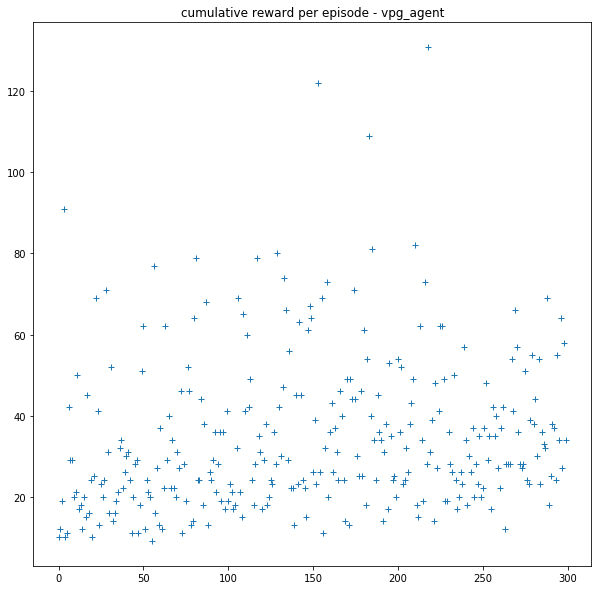

In [10]:
env = gym.make('CartPole-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = build_model(state_dim, action_dim)
q_agent = ReinforceAgent(env, model)
rewards = run_experiment_episode_train(env, q_agent, 300)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - vpg_agent')

# Reinforce with memory - discrete action

In [11]:
import gym
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, multiply, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop, Adam


class ReinforceAgentWithMemory(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .01, memory_size = 3):
        super().__init__(env,  gamma, epsilon)
        
        self.model = compiled_model
        
        self.model.summary()
        
        self.episode = []
        self.memory_size = memory_size
        self.episodes = []
        
    def act(self, state):
        state = state.reshape(1, -1)
        prob = self.model.predict(state, batch_size=1).flatten()
        action = np.random.choice(self.action_dim, 1, p=prob)[0]
        
        return action

    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward]))
        if done is True:
            episode = np.asarray(self.episode)
            self.episode = []
            discounted_return = discount_cumsum(episode[:,2], self.gamma)
            X = np.vstack(episode[:,0])
            Y = np.zeros((len(episode), self.action_dim))
            Y[np.arange(len(episode)), episode[:,1].astype(int)] = 1
            if len(self.episodes) == self.memory_size:
                Xs = np.vstack([ep[0] for ep in self.episodes])
                Ys = np.vstack([ep[1] for ep in self.episodes])
                discounted_returns = np.hstack([ep[2] for ep in self.episodes])
                discounted_returns -= discounted_returns.mean()
                discounted_returns /= discounted_returns.std()
                self.episodes = []
                loss = policy_gradient_loss(discounted_returns)
                self.model.compile(loss=loss, optimizer=Adam(learning_rate=1e-2))
                self.model.train_on_batch(Xs,Ys)
            else:
                self.episodes.append([X,Y,discounted_return])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_state (InputLayer)     [(None, 4)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 48.0
episode: 1 - cum reward 9.0
episode: 2 - cum reward 17.0
episode: 3 - cum reward 13.0
episode: 4 - cum reward 15.0
episode: 5 - cum reward 14.0
episode: 6 - cum reward 26.0
episode: 7 - cum reward 24.0
episode: 8 - cum reward 

episode: 235 - cum reward 200.0
episode: 236 - cum reward 114.0
episode: 237 - cum reward 158.0
episode: 238 - cum reward 160.0
episode: 239 - cum reward 112.0
episode: 240 - cum reward 193.0
episode: 241 - cum reward 124.0
episode: 242 - cum reward 193.0
episode: 243 - cum reward 167.0
episode: 244 - cum reward 200.0
episode: 245 - cum reward 200.0
episode: 246 - cum reward 200.0
episode: 247 - cum reward 200.0
episode: 248 - cum reward 200.0
episode: 249 - cum reward 200.0
episode: 250 - cum reward 200.0
episode: 251 - cum reward 200.0
episode: 252 - cum reward 200.0
episode: 253 - cum reward 200.0
episode: 254 - cum reward 200.0
episode: 255 - cum reward 200.0
episode: 256 - cum reward 200.0
episode: 257 - cum reward 200.0
episode: 258 - cum reward 200.0
episode: 259 - cum reward 200.0
episode: 260 - cum reward 200.0
episode: 261 - cum reward 200.0
episode: 262 - cum reward 200.0
episode: 263 - cum reward 200.0
episode: 264 - cum reward 200.0
episode: 265 - cum reward 194.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - vpg_agent large memory')

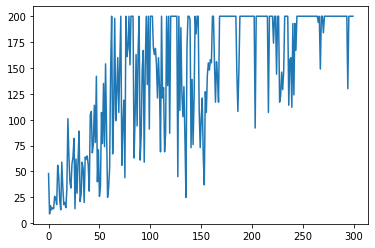

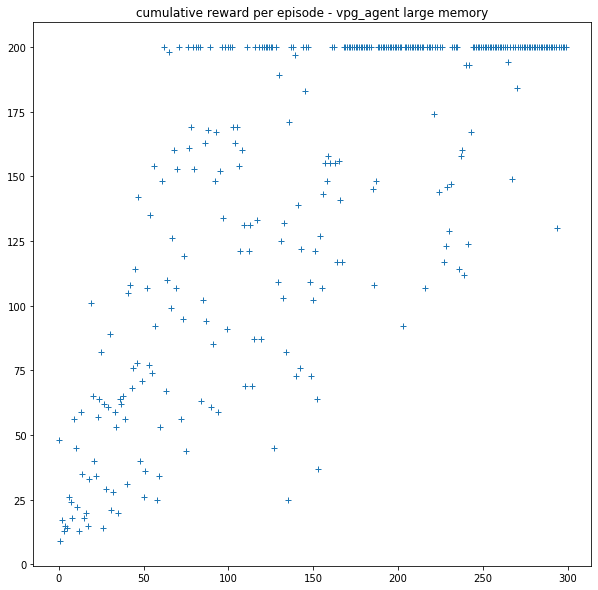

In [12]:
env = gym.make('CartPole-v0')
model = build_model(state_dim, action_dim)
q_agent = ReinforceAgentWithMemory(env, model)
rewards = run_experiment_episode_train(env, q_agent, 300)
plt.plot(rewards)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - vpg_agent large memory')

# other improvements 

### GAE(general advantage estimation) actor critic
We can rewrite the policy gradient

$\nabla_{\theta} J(\pi_{\theta}) = E_{\tau \sim \pi_{\theta}}[{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) \Phi_t}]$,

whith $\Phi_t$ could be any of:
- $\Phi_t =  G_t$
- $\Phi_t = \sum_{t'=t}^T R_{t+1} - V(s_t)$
- $\Phi_t = \sum_{t'=t}^T R_{t+1} - Q(s_t,a_t)$


For the last 2 cases we need to estimate V or Q (the critics). We do it as the same way at deepQ.
https://arxiv.org/pdf/1506.02438.pdf

$\phi_k = \arg \min_{\phi} E_{s_t, G_t \sim \pi_k}[{\left( V_{\phi}(s_t) - G_t \right)^2}]$

### off policy
To build an experience replay for policy gradient, it is necessary to unbias the experiences.
https://arxiv.org/pdf/1205.4839.pdf

### clipping